**Identifying PNs that are upstream of KCs**
<br>
These PNs will be used to identify bifuricating paths to the Lateral Horn and Mushroom Body. This script depends on edge lists generated by *generate_updated_adjs.py*. Below are the basic imports required for the script, including notably contools (https://github.com/mwinding/connectome_tools) and python-catmaid (pymaid).

In [ ]:
import pymaid
import contools
import pandas as pd
import numpy as np
from contools import generate_adjs, Celltype_Analyzer, Celltype, Promat

from pymaid_creds import url, name, password, token
rm = pymaid.CatmaidInstance(url, token, name, password)
pairs_path = 'data/pairs/pairs-2021-04-06.csv'
pairs = contools.Promat.get_pairs(pairs_path)

# load a-d edges with 1% input threshold
edges = pd.read_csv('data/edges_threshold/ad_pairwise-input-threshold-0.01_all-edges_2022-02-03.csv', index_col=0)
edges_syn3 = pd.read_csv('data/edges_threshold/ad_pairwise-threshold-3syn_all-edges_2022-02-03.csv', index_col=0)

Identify neurons upstream of KCs with 1% input threshold or 3-synapse threshold (both axo-dendritic)

In [ ]:

# %%
# find PNs upstream of KCs

KCs = pymaid.get_skids_by_annotation('mw KC')

# upstream of KCs using 1% input threshold
upstream_KC = Promat.upstream_multihop(edges=edges, sources=KCs, hops=1)
upstream_KC = Celltype(name='us-KCs', skids=upstream_KC)

# upstream of KC using 3 syn threshold
upstream_KC_syn3 = Promat.upstream_multihop(edges=edges_syn3, sources=KCs, hops=1)
upstream_KC_syn3 = Celltype(name='us-KCs-syn3', skids=upstream_KC_syn3)

# how many PNs and somatosensory PNs are upstream of KCs?
PNs = Celltype_Analyzer.get_skids_from_meta_annotation('mw brain PNs')
PNs_somato = Celltype_Analyzer.get_skids_from_meta_annotation('mw brain PNs-somato')

In [3]:
print(f'Using a 1% input threshold (pairwise):')
print(f'\t{len(np.unique(np.intersect1d(PNs, upstream_KC.skids)))/len(np.unique(PNs))*100:.1f}% of PNs are upstream of KCs')
print(f'\t{len(np.unique(np.intersect1d(PNs_somato, upstream_KC.skids))/len(np.unique(PNs_somato)))*100}% of Somatosensory PNs are upstream of KCs')
print('')
print(f'Using a 3-synapse threshold (pairwise):')
print(f'\t{len(np.unique(np.intersect1d(PNs, upstream_KC_syn3.skids)))/len(np.unique(PNs))*100:.1f}% of PNs are upstream of KCs')
print(f'\t{len(np.unique(np.intersect1d(PNs_somato, upstream_KC_syn3.skids))/len(np.unique(PNs_somato)))*100}% of Somatosensory PNs are upstream of KCs')

Using a 1% input threshold (pairwise):
	34.4% of PNs are upstream of KCs
	0% of Somatosensory PNs are upstream of KCs

Using a 3-synapse threshold (pairwise):
	29.2% of PNs are upstream of KCs
	0% of Somatosensory PNs are upstream of KCs


**Which PNs are upstream of KCs?**
Because no somatosensory PNs were observed, those will be ignored below

In [ ]:
PN_groups = Celltype_Analyzer.get_skids_from_meta_annotation('mw brain PNs', split=True)
PN_groups = [Celltype(name=PN_groups[1][i][3:], skids=PN_groups[0][i]) for i in range(len(PN_groups[0]))] # set up Celltype objects

cts = Celltype_Analyzer(PN_groups)
cts.set_known_types([upstream_KC, upstream_KC_syn3])

In [5]:
print('Fraction of each PN type that are upstream of KCs')
cts.memberships().loc[['us-KCs', 'us-KCs-syn3']]

Fraction of each PN type that are upstream of KCs


,mPN (28),tPN (10),uPN (42),vPN (10),Pdf-LaNs (8),gustatory-external 2nd_order PN (112),enteric 2nd_order PN (24),olfactory 2nd_order PN (64),visual 2nd_order PN (18),thermo-warm 2nd_order PN (4),thermo-cold 2nd_order PN (8),gustatory-pharyngeal 2nd_order PN (60)
us-KCs,0.285714,0.9,1.000000,0.3,0.25,0.142857,0.0,0.718750,0.277778,0.0,0.875,0.1
us-KCs-syn3,0.214286,0.6,0.952381,0.3,0.00,0.098214,0.0,0.640625,0.166667,0.0,0.500,0.1


Based on these results, I prefer the 1% input threshold. It captures all uPNs as expected and more coverage on other modalities. However, overall it seems fairly comparable

Fraction upstream of KCs


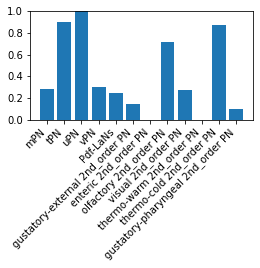

In [11]:
# plot cell types
cts.set_known_types([upstream_KC])
print('Fraction PNs upstream of KCs')
cts.plot_memberships(path='plots/PNs-upstream-KC.pdf', figsize=(4,2), celltype_colors=['tab:blue', 'white'])